<a href="https://colab.research.google.com/github/rahulprasanth487/S3-STORAGE-GCS-migration/blob/main/List_new_file_in_S3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install boto3 python-dateutil

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.8/84.8 kB 6.6 MB/s eta 0:00:00


In [5]:
import boto3
import datetime
from dateutil.parser import parse

def list_s3_files_between_dates(bucket_name, prefix='', start_date=None, end_date=None):

    s3_client = boto3.client(
        's3',
        aws_access_key_id='xxxx',
        aws_secret_access_key='xxxx',
        region_name='us-east-1'
    )

    # Convert string dates to datetime objects if provided as strings
    if isinstance(start_date, str):
        start_date = parse(start_date)
    if isinstance(end_date, str):
        end_date = parse(end_date)

    # Get list of all objects in the bucket with the given prefix
    response = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

    # Check if there are contents
    if 'Contents' not in response:
        print(f"No objects found in bucket '{bucket_name}' with prefix '{prefix}'")
        return []

    # Filter objects by last modified date
    filtered_objects = []

    for obj in response['Contents']:
        last_modified = obj['LastModified']

        # Remove timezone info for comparison if datetime objects don't have it
        if start_date and not start_date.tzinfo:
            last_modified = last_modified.replace(tzinfo=None)

        # Check if the object was uploaded within the date range
        if ((not start_date or last_modified >= start_date) and
            (not end_date or last_modified <= end_date)):
            filtered_objects.append({
                'Key': obj['Key'],
                'Size': obj['Size'],
                'LastModified': last_modified
            })

    # Handle pagination for buckets with more than 1000 objects
    while response.get('IsTruncated', False):
        response = s3_client.list_objects_v2(
            Bucket=bucket_name,
            Prefix=prefix,
            ContinuationToken=response['NextContinuationToken']
        )

        for obj in response['Contents']:
            last_modified = obj['LastModified']

            # Remove timezone info for comparison if datetime objects don't have it
            if start_date and not start_date.tzinfo:
                last_modified = last_modified.replace(tzinfo=None)

            # Check if the object was uploaded within the date range
            if ((not start_date or last_modified >= start_date) and
                (not end_date or last_modified <= end_date)):
                filtered_objects.append({
                    'Key': obj['Key'],
                    'Size': obj['Size'],
                    'LastModified': last_modified
                })

    return filtered_objects

In [6]:

if __name__ == "__main__":
    bucket_name = 'sample-98775'
    prefix =''

    start_date = '2025-04-10T00:00:00'  # April 10, 2025
    end_date = '2025-04-22T23:59:59'    # April 22, 2025

    filtered_files = list_s3_files_between_dates(
        bucket_name=bucket_name,
        prefix=prefix,
        start_date=start_date,
        end_date=end_date
    )

    print(f"Found {len(filtered_files)} files uploaded between {start_date} and {end_date}:")
    for i, file in enumerate(filtered_files, 1):
        print(f"{i}. {file['Key']} - {file['Size']} bytes - Last modified: {file['LastModified']}")

    # Calculate total size
    total_size = sum(file['Size'] for file in filtered_files)
    print(f"\nTotal size: {total_size} bytes ({total_size / (1024*1024):.2f} MB)")

Found 5 files uploaded between 2025-04-10T00:00:00 and 2025-04-22T23:59:59:
1. A.png - 38328 bytes - Last modified: 2025-04-21 09:02:15
2. H.png - 19302 bytes - Last modified: 2025-04-21 09:02:14
3. P.png - 31673 bytes - Last modified: 2025-04-21 09:02:14
4. R.png - 33047 bytes - Last modified: 2025-04-21 09:02:14
5. V.png - 33123 bytes - Last modified: 2025-04-21 09:02:14

Total size: 155473 bytes (0.15 MB)


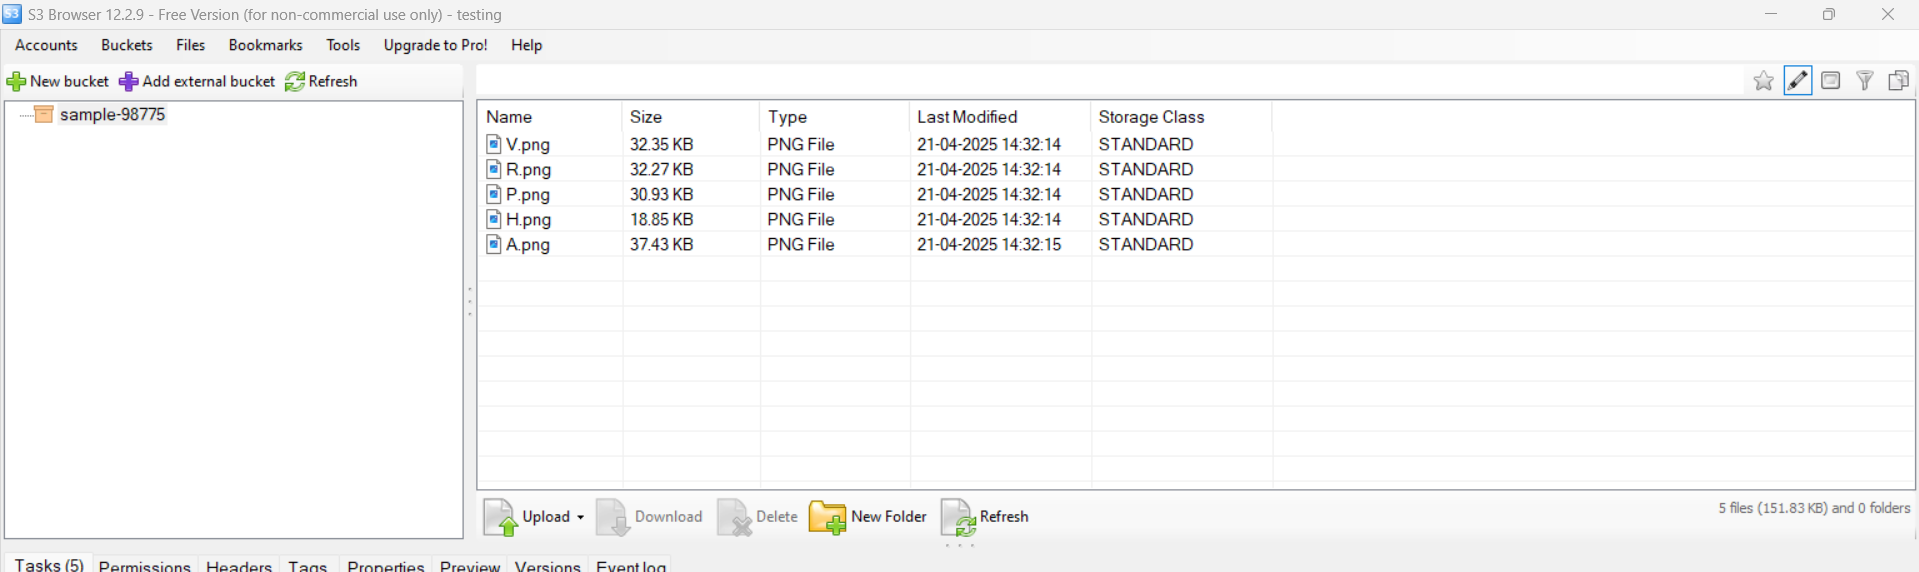